### This  file is specific to preprocessing and first-round data cleaning requirements. Take the new JSON files generated from here and use it separately for the purposes of exploration and modelling

In [1]:
import numpy as np
import scipy
import random
import urllib
import matplotlib.pyplot as plt
import json

In [2]:
random.seed(0) #set an initial seed so that we can reproduce consistently

In [3]:
def readJSONfromFile(fname):
    yelp_data = []
    with open(fname) as f:
        for line in f:
            yelp_data.append(json.loads(line))
    return yelp_data

In [4]:
data = readJSONfromFile('data/yelp_academic_dataset_business.json')

In [5]:
print("The dataset has {} businesses".format(len(data)))

The dataset has 144072 businesses


In [6]:
data[11]

{u'address': u'1500 N Green Valley Pkwy, Ste 230',
 u'attributes': [u'Alcohol: none',
  u"Ambience: {'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",
  u'BusinessAcceptsCreditCards: True',
  u"BusinessParking: {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
  u'Caters: True',
  u'GoodForKids: True',
  u"GoodForMeal: {'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'breakfast': False, 'brunch': False}",
  u'HasTV: True',
  u'NoiseLevel: quiet',
  u'OutdoorSeating: False',
  u'RestaurantsAttire: casual',
  u'RestaurantsDelivery: False',
  u'RestaurantsGoodForGroups: True',
  u'RestaurantsPriceRange2: 1',
  u'RestaurantsReservations: False',
  u'RestaurantsTableService: False',
  u'RestaurantsTakeOut: True',
  u'WiFi: no'],
 u'business_id': u'42romV8altAeuZuP2OC1gw',
 u'categories': [u'Hawaiian', u'Restaurants', u'Barbeq

### Restaurant Data preprocessing

#### We only want restaurant data. Yelp data is clean, in the sense that every business which is a restaurant, has a restaurant category at the least. Bakeries or sometime coffee places are not tagged restaurant, which is acceptable

In [7]:
restaurant_data = []
restaurant_id_set = set()   #set of ids of business = restaurant useful for processing of other json files
for business in data:
    if business["categories"]!= None and "Restaurants" in business["categories"]:
        restaurant_data.append(business)
        restaurant_id_set.add(business["business_id"])
        

In [9]:
print("The number of businesses which are just restaurants is {} of {} businesses".\
      format(len(restaurant_data), len(data)))

The number of businesses which are just restaurants is 48485 of 144072 businesses


In [10]:
with open('data/yelp_restaurant_data.json', 'w') as outfile:
    json.dump(restaurant_data, outfile)


### User review data processing
#### Choose only those reviews pertaining to restaurants and store the reduced set of reviews

In [11]:
yelp_user_review_data = []
with open("data/yelp_academic_dataset_review.json", "U") as f:
    for line in f:
        review = json.loads(line)
        if review["business_id"] in restaurant_id_set:
            yelp_user_review_data.append(review)

In [13]:
print("Number of user reviews pertaining to restaurants is {}".format(len(yelp_user_review_data)))

Number of user reviews pertaining to restaurants is 2577298


In [14]:
with open('data/yelp_user_review_data.json', 'w') as outfile:
    json.dump(yelp_user_review_data, outfile)

In [16]:
f.close()
outfile.close()

### User data processing
#### the user.json file has many attributes for each JSON object which are not relevant to our task. These are removed and a new json file is created

#### The attributes retained has the review_count and the average_stars which is across all Yelp business. We can get the right count from the restaurant review data specifically.
#### We only want the users who have written atleast one review (i.e. gone to one restaurant at the least). 

In [17]:
yelp_user_data = []
keep_property_arr= ["user_id","name","yelping_since","review_count", "average_stars","fans"]  
#these are the attributes to keep

with open("data/yelp_academic_dataset_user.json", "U") as f:
    for line in f:
        user = json.loads(line)
        user_jsobobj = dict()
        for property in keep_property_arr:
            user_jsobobj[property] = user[property]
        yelp_user_data.append(user_jsobobj)
        

In [18]:
yelp_user_data[100]

{'average_stars': 3.76,
 'fans': 15,
 'name': u'Derek',
 'review_count': 341,
 'user_id': u'i3aWph4gS_pUEV8f5i5lzg',
 'yelping_since': u'2013-05-02'}

In [19]:
len(yelp_user_data)

1029432

In [20]:
with open('data/yelp_user_data.json', 'w') as outfile:
    json.dump(yelp_user_data, outfile)
    print("File {} written".format("yelp_user_data.json"))
    outfile.close()
    f.close()

File yelp_user_data.json written


#### Generate the dictionaries Iu and Ui

In [21]:
yelp_restaurant_data = []
with open("data/yelp_restaurant_data.json","U") as infile:
    yelp_restaurant_data = json.load(infile)
infile.close()

In [23]:
#with open("data/yelp_academic_dataset_review.json","U") as infile:
yelp_user_review_data = []
with open("data/yelp_user_review_data.json","U") as infile:
    yelp_user_review_data = json.load(infile)
print('File read')

File read


In [24]:
# we have now the entire dataset limited to the restaurants and users concerned in the reviews section. The assumption
# is we only consider these users and restaurants for prediction


In [25]:
yelp_restaurant_set = set() 
yelp_restaurant_Ui = dict() #list of users who have visited (aka reviewed) each restaurant
yelp_user_set = set()
yelp_user_Iu = dict()  #list of restaurants visited by each user

In [26]:
for review in yelp_user_review_data:
    user_id,restaurant_id = review["user_id"], review["business_id"]
    if restaurant_id not in yelp_restaurant_set:
        yelp_restaurant_set.add(restaurant_id)
    if user_id not in yelp_user_set:
        yelp_user_set.add(user_id)
        
    if restaurant_id not in yelp_restaurant_Ui:
        yelp_restaurant_Ui[restaurant_id] = [user_id]
    else:
        yelp_restaurant_Ui[restaurant_id].append(user_id)
        
    if user_id not in yelp_user_Iu:
        yelp_user_Iu[user_id] = [restaurant_id]
    else:
        yelp_user_Iu[user_id].append(restaurant_id)

In [27]:
print "Number of restaurants: {} {}".format(len(yelp_restaurant_set), len(yelp_restaurant_Ui))
print "Number of users: {} {}".format(len(yelp_user_set),len(yelp_user_Iu))

Number of restaurants: 48485 48485
Number of users: 721779 721779


In [28]:
print "Number of users who have reviewed Ohana Hawaiian BBQ with business id = 42romV8altAeuZuP2OC1gw is {}".format\
(len(yelp_restaurant_Ui["42romV8altAeuZuP2OC1gw"]))

Number of users who have reviewed Ohana Hawaiian BBQ with business id = 42romV8altAeuZuP2OC1gw is 38


In [29]:
print "Number of restaurants visited by user umZPUpLSJuCTXLckxA4nmg is {}".format\
(len(yelp_user_Iu["umZPUpLSJuCTXLckxA4nmg"]))

Number of restaurants visited by user umZPUpLSJuCTXLckxA4nmg is 86


In [30]:
with open("data/yelp_restaurant_Ui.json","w") as outfile:
    json.dump(yelp_restaurant_Ui,outfile)
print("Ui File written")
outfile.close()

Ui File written


In [31]:
with open("data/yelp_user_Iu.json","w") as outfile:
    json.dump(yelp_user_Iu,outfile)

print("File written")
outfile.close()

File written


In [37]:
# A plot of number of reviews given by each user

In [32]:
user_count_dict =dict()
for user in yelp_user_Iu:
    if len(yelp_user_Iu[user]) not in user_count_dict:
        user_count_dict[len(yelp_user_Iu[user])] = 1
    else:
        user_count_dict[len(yelp_user_Iu[user])]+=1

In [33]:
#user_count_dict

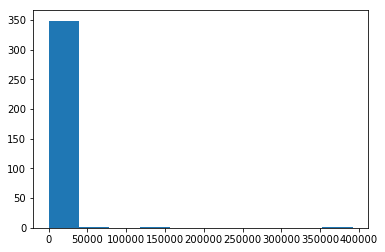

In [36]:
plt.hist(user_count_dict.values())
plt.show()

In [38]:
rest_count =0

for rest in yelp_restaurant_Ui:
    if len(yelp_restaurant_Ui[rest]) <=10:
        rest_count+=1

In [39]:
print "Number of restaurants who have been reviewed by less than 10 users are: {} of {} restaurants".\
format(rest_count, len(yelp_restaurant_Ui))

Number of restaurants who have been reviewed by less than 10 users are: 17998 of 48485 restaurants
